# Imports

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from matplotlib import pyplot as plt
import torchvision
from torch.nn import functional as F
import re
import collections
import math
from torch.utils.data import DataLoader

# Visualization

In [2]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    num_rows, num_cols = matrices.shape[:2]
    
    # Create figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                            sharex=True, sharey=True, squeeze=False)
    
    # Plot each heatmap
    for i in range(num_rows):
        for j in range(num_cols):
            ax = axes[i, j]
            pcm = ax.imshow(matrices[i, j].detach().cpu().numpy(), cmap=cmap)
            
            # Remove ticks for cleaner look
            ax.set_xticks([])
            ax.set_yticks([])
        
            # Add labels only where needed
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    
    # Add colorbar
    plt.colorbar(pcm, ax=axes.ravel().tolist())

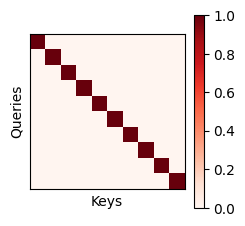

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# Attention Pooling By Similarity

## Kernels and Data

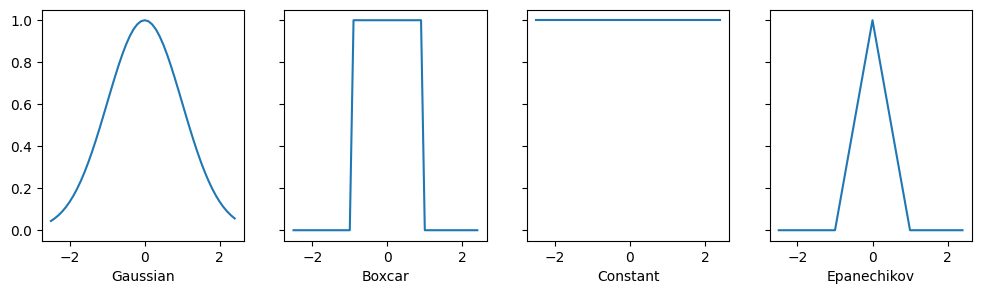

In [4]:
# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

fig, axes = plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

plt.show()


## Attention Pooling via Nadaraya–Watson Regression

To see Nadaraya–Watson estimation in action, let’s define some training data. In the following we use the dependency where is drawn from a normal distribution with zero mean and unit variance. We draw 40 training examples.

In [5]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

Calculating attention weights

In [6]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

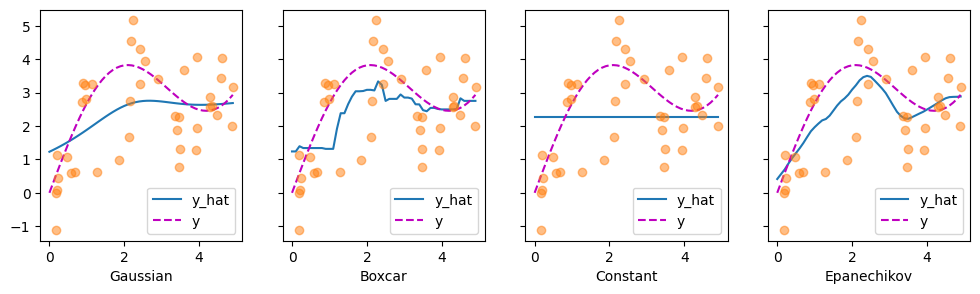

In [7]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

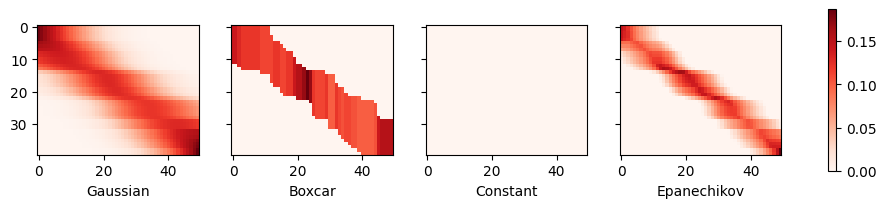

In [8]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

The estimates for the Gaussian, Boxcar, and Epanechikov kernels are similar. They contain similar attention weights despite coming from different fuctional forms of the kernel

## Adapting Attention Pooling

We can replce the Gaussian Kernel with a similar one with a different width. For this case, let us use the kernel $\alpha(\vec{q}, \vec{k}) = exp(-1/2\sigma^2 \left \lVert \vec{q} - \vec{k} \right \rVert^2)$ where $\sigma^2$ determines the width of the kernel

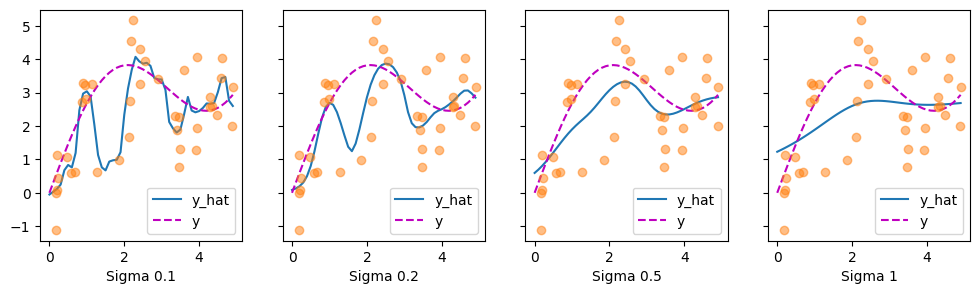

In [9]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

The narrower the width of the kernel, the less smooth the estimate but they do adapt better to local variations

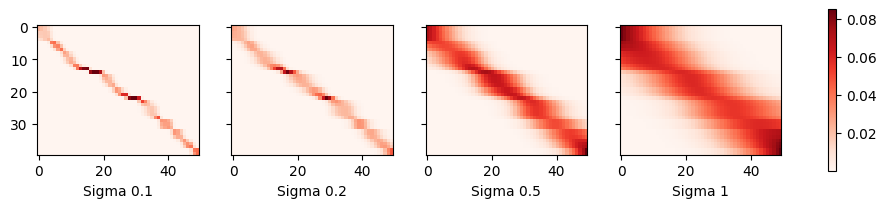

In [10]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

The narrower the kernel, the narrow the large attention weights are

# Attention Scoring Functions

Since dot product is easier to calculate as compared to distance functions, we can try to come to a dot product attention function

Considering the gaussian attention without exponentiation, $a(\vec{q}, \vec{k_i}) = -\frac{1}{2} \left \Vert \vec{q} - \vec{k_i} \right \Vert^2 = \vec{q}^\top\vec{k_i} - \frac{1}{2} \left \Vert \vec{k_i} \right \Vert^2 - \frac{1}{2} \left \Vert \vec{q} \right \Vert^2$

Assuming that normalizations would cause the $\frac{1}{2} \left \Vert \vec{q} \right \Vert^2$ term to disappear and constant values of $\left \Vert \vec{k_i} \right \Vert$ due to batch and layer normalization would ensure that the terms removal will have no major change in the outcome, we come to a dot product kernel. We scale it by $\frac{1}{\sqrt{d}}$

$\alpha(\vec{q}, \vec{k_i}) = softmax(a(\vec{q}, \vec{k_i})) = \frac{exp(\vec{q}^\top \vec{k_i} / \sqrt{d})}{\sum_i exp(\vec{q}^\top \vec{k_j} / \sqrt{d})}$

## Masked Softmax Operation

The implementation cheats ever so slightly by setting the values of $v_i$ for $i\geq l$, to zero. Moreover, it sets the attention weights to a large negative number, such as $-10^6$ in order to make their contribution to gradients and values vanish in practice. This is done since linear algebra kernels and operators are heavily optimized for GPUs and it is faster to be slightly wasteful in computation rather than to have code with conditional (if then else) statements.

In [11]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [12]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.7275, 0.2725, 0.0000, 0.0000],
         [0.3012, 0.6988, 0.0000, 0.0000]],

        [[0.4146, 0.3245, 0.2609, 0.0000],
         [0.4552, 0.2948, 0.2500, 0.0000]]])

In [13]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3467, 0.3439, 0.3094, 0.0000]],

        [[0.4461, 0.5539, 0.0000, 0.0000],
         [0.2913, 0.1821, 0.2512, 0.2754]]])

## Batch Matrix Multiplication

In [14]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
result = torch.bmm(Q, K)
print(f"Shape of batch matrix multiplication result: {result.shape}")
# Verify if shape matches expected (2, 3, 6)
assert result.shape == (2, 3, 6), f"Expected shape (2, 3, 6), but got {result.shape}"

Shape of batch matrix multiplication result: torch.Size([2, 3, 6])


## Scaled Dot Product Attention

We use the formula $softmax(\vec{Q}\vec{K}^\top/\sqrt{d})\vec{V} \in \mathbb{R^{n \times v}}$ to calculate the attention weights.

In [16]:
class DotProductAttention(nn.Module): 
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [18]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
# Check shape manually since d2l might not be available
result = attention(queries, keys, values, valid_lens)
assert result.shape == (2, 1, 4), f"Expected shape (2, 1, 4), but got {result.shape}"
print(f"Attention output shape: {result.shape}")

Attention output shape: torch.Size([2, 1, 4])


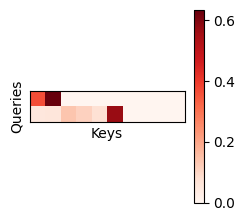

In [19]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

Since valid length is from 2-6, we do not see any attention to ranges outside of this

## Additive Attention

In [21]:
class AdditiveAttention(nn.Module): 
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [23]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
# Check shape manually since d2l might not be available
result = attention(queries, keys, values, valid_lens)
assert result.shape == (2, 1, 4), f"Expected shape (2, 1, 4), but got {result.shape}"
print(f"Attention output shape: {result.shape}")

Attention output shape: torch.Size([2, 1, 4])


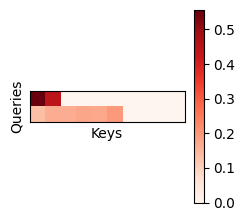

In [24]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

# The Bahdanau Attention Mechanism

In [39]:
class Encoder(nn.Module):  
    """The base encoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    def forward(self, X, *args):
        raise NotImplementedError
    
class Decoder(nn.Module): 
    """The base decoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError
    
def init_seq2seq(module): 
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(Encoder): 
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

class EncoderDecoder(nn.Module):
    """The base class for the encoder--decoder architecture."""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]
    
class Seq2Seq(EncoderDecoder): 
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.encoder = encoder
        self.decoder = decoder
        self.tgt_pad = tgt_pad
        self.lr = lr

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
        # Calculate cross-entropy loss directly
        l = nn.CrossEntropyLoss(reduction='none')(Y_hat.reshape(-1, Y_hat.shape[-1]), Y.reshape(-1))
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()

    def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
        batch = [a.to(device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(Y.argmax(2))
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.cat(outputs[1:], 1), attention_weights

In [27]:
class AttentionDecoder(Decoder):
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

In [29]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [48]:
import torch
import torch.nn as nn
import re
import collections
from torch.utils.data import DataLoader

# Helper functions
reduce_sum = lambda x, axis: x.sum(axis=axis, keepdim=True)
astype = lambda x, y: x.type(y)

class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

class DataModule:
    def __init__(self, root='../data'):
        self.root = root

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size,
                                           shuffle=train)

class MTFraEng(DataModule):
    """The English-French dataset for machine translation."""
    
    def _download(self):
        """Load the French-English translation dataset."""
        try:
            with open('fra.txt', encoding='utf-8') as f:
                content = f.read()
                print(f"Successfully loaded fra.txt with {len(content)} characters")
                return content
        except FileNotFoundError:
            print("Error: fra.txt not found in current directory")
            raise
        except Exception as e:
            print(f"Error reading fra.txt: {e}")
            raise

    def _preprocess(self, text):
        """Preprocess the text data."""
        # Replace non-breaking space with space
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        # Insert space between words and punctuation marks
        no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
        out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
               for i, char in enumerate(text.lower())]
        return ''.join(out)

    def _tokenize(self, text, max_examples=None):
        """Tokenize the text into source and target sequences."""
        src, tgt = [], []
        lines = text.split('\n')
        print(f"Processing {len(lines)} lines from text")
        
        for i, line in enumerate(lines):
            if max_examples and i > max_examples: 
                break
            parts = line.split('\t')
            # Fix: Handle 3-column format (English, French, Attribution)
            if len(parts) >= 2:  # Changed from == 2 to >= 2
                # Skip empty tokens and ensure minimum length
                src_tokens = [t for t in f'{parts[0]} <eos>'.split(' ') if t]
                tgt_tokens = [t for t in f'{parts[1]} <eos>'.split(' ') if t]
                if len(src_tokens) > 1 and len(tgt_tokens) > 1:  # Ensure non-empty sequences
                    src.append(src_tokens)
                    tgt.append(tgt_tokens)
        
        print(f"Tokenized {len(src)} valid sentence pairs")
        return src, tgt

    def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
        """Initialize the MTFraEng dataset."""
        super(MTFraEng, self).__init__()
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.num_train = num_train
        self.num_val = num_val
        
        print("Initializing MTFraEng dataset...")
        self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
            self._download())
        print(f"Dataset initialized with {len(self.src_vocab)} source vocab and {len(self.tgt_vocab)} target vocab")

    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        """Build arrays for source and target sequences."""
        def _build_array(sentences, vocab, is_tgt=False):
            if not sentences:  # Handle empty sentences
                print("Warning: No sentences provided to _build_array")
                return torch.zeros((1, self.num_steps), dtype=torch.long), vocab, torch.zeros(1, dtype=torch.long)
            
            pad_or_trim = lambda seq, t: (
                seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
            if is_tgt:
                sentences = [['<bos>'] + s for s in sentences]
            if vocab is None:
                vocab = Vocab(sentences, min_freq=2)
            array = torch.tensor([vocab[s] for s in sentences])
            valid_len = reduce_sum(
                astype(array != vocab['<pad>'], torch.int32), 1)
            return array, vocab, valid_len
        
        src, tgt = self._tokenize(self._preprocess(raw_text),
                                self.num_train + self.num_val)
        
        # Ensure we have enough data
        if len(src) < self.num_train + self.num_val:
            print(f"Warning: Only {len(src)} examples available, requested {self.num_train + self.num_val}")
            self.num_train = min(self.num_train, len(src) - 10)
            self.num_val = min(self.num_val, len(src) - self.num_train)
        
        print(f"Building arrays with {len(src)} source and {len(tgt)} target sequences")
        src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
        
        # Ensure arrays have correct shapes
        if src_array.size(0) == 0:
            raise ValueError("No valid source sequences found")
        if tgt_array.size(0) == 0:
            raise ValueError("No valid target sequences found")
        
        print(f"Arrays built successfully. Source shape: {src_array.shape}, Target shape: {tgt_array.shape}")
        
        return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
                src_vocab, tgt_vocab)
    
    def get_dataloader(self, train):
        """Get data loader for training or validation."""
        idx = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader(self.arrays, train, idx)

    def build(self, src_sentences, tgt_sentences):
        """Build arrays from source and target sentences."""
        raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
            src_sentences, tgt_sentences)])
        arrays, _, _ = self._build_arrays(
            raw_text, self.src_vocab, self.tgt_vocab)
        return arrays

In [44]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens,
                                  num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
assert output.shape == (batch_size, num_steps, vocab_size), f"Expected shape {batch_size, num_steps, vocab_size}, but got {output.shape}"
assert state[0].shape == (batch_size, num_steps, num_hiddens), f"Expected shape {batch_size, num_steps, num_hiddens}, but got {state[0].shape}"
assert state[1][0].shape == (batch_size, num_hiddens), f"Expected shape {batch_size, num_hiddens}, but got {state[1][0].shape}"

In [49]:
# Test the dataset creation
data = MTFraEng(batch_size=128)
print(f"Source vocabulary size: {len(data.src_vocab)}")
print(f"Target vocabulary size: {len(data.tgt_vocab)}")

# Now create the model
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)

Initializing MTFraEng dataset...
Successfully loaded fra.txt with 35543272 characters
Processing 237839 lines from text
Tokenized 641 valid sentence pairs
Building arrays with 641 source and 641 target sequences
Arrays built successfully. Source shape: torch.Size([641, 9]), Target shape: torch.Size([641, 10])
Dataset initialized with 141 source vocab and 191 target vocab
Source vocabulary size: 141
Target vocabulary size: 191


In [51]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

# Move model to device
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss(reduction='none')

# Get data loaders
train_loader = data.get_dataloader(train=True)
val_loader = data.get_dataloader(train=False)

# Print data info for debugging
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Check first batch shape
for batch in train_loader:
    src, tgt, src_valid_len, tgt_shifted = batch
    print(f"Source shape: {src.shape}")
    print(f"Target shape: {tgt.shape}")
    print(f"Source valid len shape: {src_valid_len.shape}")
    print(f"Target shifted shape: {tgt_shifted.shape}")
    break

# Training loop
max_epochs = 30
for epoch in range(max_epochs):
    # Training phase
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch in train_loader:
        # Unpack batch: (src, tgt, src_valid_len, tgt_shifted)
        src, tgt, src_valid_len, tgt_shifted = [x.to(device) for x in batch]
        
        # Check for empty sequences
        if src.size(1) == 0 or tgt.size(1) == 0:
            print(f"Warning: Empty sequence detected in batch {num_batches}")
            continue
        
        optimizer.zero_grad()
        
        # For attention decoder, we need to pass src_valid_len
        # Modify the model call to handle attention decoder properly
        if hasattr(model.decoder, 'init_state') and 'enc_valid_lens' in model.decoder.init_state.__code__.co_varnames:
            # This is an attention decoder
            enc_all_outputs = model.encoder(src, src_valid_len)
            dec_state = model.decoder.init_state(enc_all_outputs, src_valid_len)
            outputs = model.decoder(tgt, dec_state)[0]
        else:
            # This is a regular decoder
            outputs = model(src, tgt)
        
        # Calculate loss with masking for padding
        l = criterion(outputs.reshape(-1, outputs.shape[-1]), tgt_shifted.reshape(-1))
        mask = (tgt_shifted.reshape(-1) != data.tgt_vocab['<pad>']).type(torch.float32)
        loss = (l * mask).sum() / mask.sum()
        
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    avg_train_loss = total_loss / num_batches if num_batches > 0 else 0
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_batches = 0
    
    with torch.no_grad():
        for batch in val_loader:
            src, tgt, src_valid_len, tgt_shifted = [x.to(device) for x in batch]
            
            # Check for empty sequences
            if src.size(1) == 0 or tgt.size(1) == 0:
                continue
            
            # For attention decoder, we need to pass src_valid_len
            if hasattr(model.decoder, 'init_state') and 'enc_valid_lens' in model.decoder.init_state.__code__.co_varnames:
                # This is an attention decoder
                enc_all_outputs = model.encoder(src, src_valid_len)
                dec_state = model.decoder.init_state(enc_all_outputs, src_valid_len)
                outputs = model.decoder(tgt, dec_state)[0]
            else:
                # This is a regular decoder
                outputs = model(src, tgt)
            
            # Calculate validation loss
            l = criterion(outputs.reshape(-1, outputs.shape[-1]), tgt_shifted.reshape(-1))
            mask = (tgt_shifted.reshape(-1) != data.tgt_vocab['<pad>']).type(torch.float32)
            loss = (l * mask).sum() / mask.sum()
            
            val_loss += loss.item()
            val_batches += 1
    
    avg_val_loss = val_loss / val_batches if val_batches > 0 else 0
    
    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("Training completed!")

Training on cuda
Training batches: 4
Validation batches: 2
Source shape: torch.Size([128, 9])
Target shape: torch.Size([128, 9])
Source valid len shape: torch.Size([128, 1])
Target shifted shape: torch.Size([128, 9])
Epoch 5/30, Train Loss: 1.7075, Val Loss: 3.1389
Epoch 10/30, Train Loss: 0.9290, Val Loss: 2.6226
Epoch 15/30, Train Loss: 0.5597, Val Loss: 2.4154
Epoch 20/30, Train Loss: 0.4194, Val Loss: 2.4317
Epoch 25/30, Train Loss: 0.3878, Val Loss: 2.2799
Epoch 30/30, Train Loss: 0.3653, Val Loss: 2.4334
Training completed!


In [52]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU.

    Defined in :numref:`sec_seq2seq_training`"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score


In [56]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), num_steps=data.num_steps, device=device)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

Processing 4 lines from text
Tokenized 4 valid sentence pairs
Building arrays with 4 source and 4 target sequences
Arrays built successfully. Source shape: torch.Size([4, 9]), Target shape: torch.Size([4, 10])
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', '<unk>', '.'], bleu,0.512


Processing 1 lines from text
Tokenized 1 valid sentence pairs
Building arrays with 1 source and 1 target sequences
Arrays built successfully. Source shape: torch.Size([1, 9]), Target shape: torch.Size([1, 10])


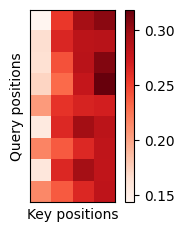

In [59]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), device, data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

# Multi-Head Attention

In [60]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)
        
    def forward(self, queries, keys, values, valid_lens):
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, self.num_heads, dim=0)
        outputs = self.attention(queries, keys, values, valid_lens)
        outputs = self.transpose_output(outputs)
        outputs = self.W_o(outputs)
        return outputs

    def transpose_qkv(self, X):
        """Transpose the last two dimensions of tensor X."""
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        X = X.permute(0, 2, 1, 3)
        return X.reshape(-1, X.shape[2], X.shape[3])
    
    def transpose_output(self, X):
        """Transpose the last two dimensions of tensor X."""
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)

In [61]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
assert attention(X, Y, Y, valid_lens).shape == (batch_size, num_queries, num_hiddens), f"Expected shape {batch_size, num_queries, num_hiddens}, but got {attention(X, Y, Y, valid_lens).shape}"

# Self-Attention

In [62]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
assert attention(X, X, X, valid_lens).shape == (batch_size, num_queries, num_hiddens), f"Expected shape {batch_size, num_queries, num_hiddens}, but got {attention(X, X, X, valid_lens).shape}"